In [ ]:
pip install -r requirements.txt

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Donated by: P. Savicky Institute of Computer Science, AS of CR Czech Republic savicky '@' cs.cas.cz

In [2]:
from pathlib import Path
from zipfile import ZipFile

zip_path = Path(r"Magic-dataset-24-sep-25/magic+gamma+telescope.zip")
out_dir = zip_path.parent / "magic_extracted"

out_dir.mkdir(parents=True, exist_ok=True)
with ZipFile(zip_path, "r") as zf:
    zf.extractall(out_dir)

print("Extracted to:", out_dir)

Extracted to: Magic-dataset-24-sep-25\magic_extracted


In [3]:
cols = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1",
    "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist",
    "class"
]
df = pd.read_csv("Magic-dataset-24-sep-25/magic_extracted/magic04.data",header=None, names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
df['class'] = (df['class'] == 'g').astype(int)

In [5]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


Train, validation, test datasets

In [6]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

C:\Users\VeeneetKumar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def scale_dataset(dataframe, oversample=False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)

    data = np.hstack((x, np.reshape(y, (-1, 1))))
    return data, x, y

In [8]:
print(len(train[train['class'] == 1])) # gamma
print(len(train[train['class'] == 0])) # hadron

7437
3975


In [9]:
train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)

In [10]:
len(y_train)

14874

In [11]:
sum(y_train == 1)

np.int64(7437)

In [16]:
sum(y_train == 0)

np.int64(7378)

Neural Net

In [15]:
import tensorflow as tf

In [44]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()



In [45]:
def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    history = nn_model.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
    )

    return nn_model, history

64 nodes, dropouts 0, lr 0.001, batch size 128


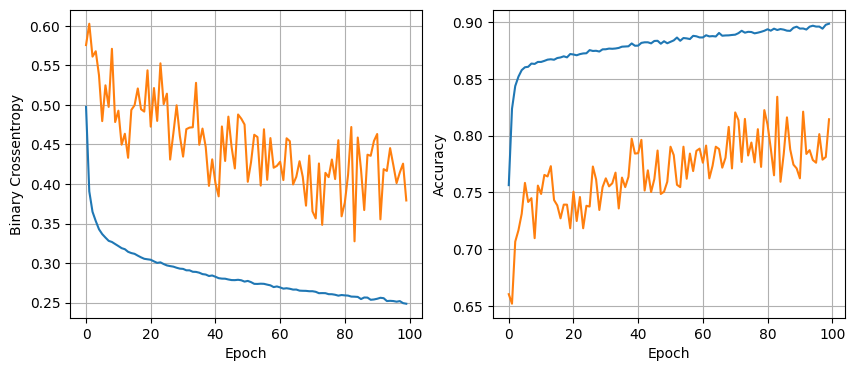

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.3070
64 nodes, dropouts 0.2, lr 0.001, batch size 128


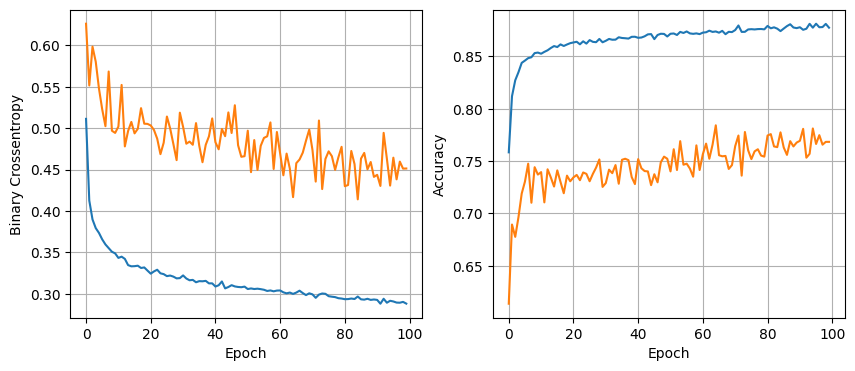

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.2898


In [49]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
#for num_nodes in [16, 32, 64]:
for num_nodes in [64]:
    for dropout_prob in [0, 0.2]:
        #for lr in [0.01, 0.005, 0.001]:
        for lr in [0.001]:
            #for batch_size in [32,64,128]:
            for batch_size in [128]:
                print(f'{num_nodes} nodes, dropouts {dropout_prob}, lr {lr}, batch size {batch_size}')
                model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot_history(history)
                val_loss = model.evaluate(x_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [51]:
y_pred = least_loss_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1335
           1       0.87      0.95      0.91      2469

    accuracy                           0.87      3804
   macro avg       0.88      0.84      0.86      3804
weighted avg       0.88      0.87      0.87      3804

